# **Avaliação 2** — Introdução ao Aprendizado de Máquina (ENGG67)
---

### **Docente:**
Antônio C. L. Fernandes Jr.

### **Discentes:**
- Beatriz Pereira Espinheira  
- Djair Maykon de Novaes Miranda

---

### **Questão1**
Utilizando o banco de dados [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) aborde o problema de classificação utilizando o algoritmo k-NN. Implemente o classificador em Jupyter
Notebook. Utilize o procedimento de validação cruzada para avaliar o seu resultado e todas
as medidas discutidas em sala para interpretar o resultado da classificação binária.

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo


breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

df = pd.concat([X, y], axis=1)


 ### **Normalização**
Como os métodos baseados em distância são diretamente afetados pela escala dos atributos, e os dados do dataset estão em escalas muito **diferentes**, é preciso promover uma **normalização dos dados** para minimizar esse problema.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.squeeze().values


---
## **Parte 1: Amostragem**
O método de amortragem escolhido foi o de **Validação Cruzada (𝑟-fold cross validation estratificado)**. <br/>
Na atividade anterior vimos que o conjunto de dados é levemente desbalanceado, Logo, essa variação do método de validação cruzada, por manter nas partições proporções semelhantes à do conjunto, é capaz de melhorar a capacidade preditiva do modelo.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  #transforma B e M em 0 e 1

#agrupa as classes no dataset (somente para vizualização)
sort_idx = np.argsort(y_encoded)
X_sorted = X[sort_idx]
y_sorted = y_encoded[sort_idx]

In [ ]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, class_labels=["B", "M"]):
    n_samples = len(X)
    x_range = np.arange(n_samples)

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        indices = np.full(n_samples, np.nan)
        indices[train_idx] = 0
        indices[test_idx] = 1

        # Treino/Teste
        ax.scatter(x_range, [i + 0.5] * n_samples, c=indices, marker="_", lw=lw, cmap=plt.cm.plasma)

        # Proporções de classes no fold
        y_test = y[test_idx]
        props = {class_labels[k]: v / len(y_test) for k, v in zip(*np.unique(y_test, return_counts=True))}
        ax.text(n_samples + 5, i + 0.5, " | ".join([f"{k}: {v:.1%}" for k, v in props.items()]), va="center", fontsize=9)

    # Linha com a classe real (B/M)
    ax.scatter(x_range, [-1] * n_samples, c=y, marker="_", lw=lw,
               cmap=ListedColormap(["#ff3366", "#94ff81"]))

    # Eixos e limites
    ax.set(
        yticks=np.append(np.arange(n_splits) + 0.5, -1),
        yticklabels=[f"Fold {i+1}" for i in range(n_splits)] + ["Classe (B/M)"],
        xlabel="Índice da Amostra",
        ylabel="Fold"
    )
    ax.set_xlim(0, n_samples + 100)
    ax.set_ylim(-2, n_splits + 2)

    # Legenda
    legend = ax.legend(
        handles=[
            plt.Line2D([0], [0], color=plt.cm.plasma(0.), lw=4, label="Treino"),
            plt.Line2D([0], [0], color=plt.cm.plasma(1.), lw=4, label="Teste"),
            plt.Line2D([0], [0], color="#ff3366", lw=4, label="Classe B"),
            plt.Line2D([0], [0], color="#94ff81", lw=4, label="Classe M"),
        ],
        loc="upper left",
        title="Legenda:"
    )
    legend.get_title().set_fontsize(10)



In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

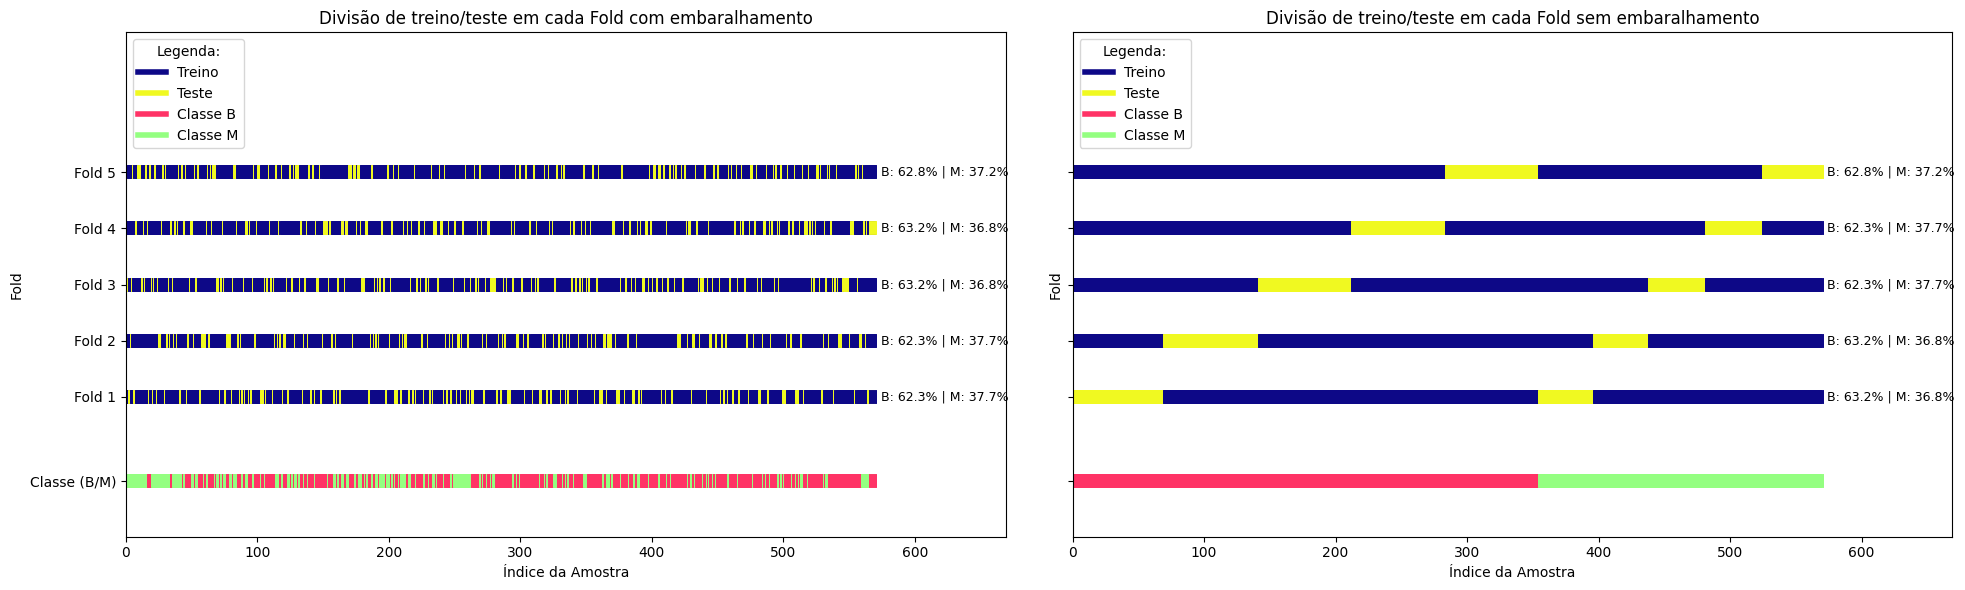

In [ ]:
cv2 = StratifiedKFold(n_splits=5)

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

#com shuffle
axes[0].set_title("Divisão de treino/teste em cada Fold com embaralhamento")
plot_cv_indices(cv, X_scaled, y_encoded, axes[0], n_splits=5)

#sem shuffle (apenas para mostrar o comportamento do r-fold estratificado)
axes[1].set_title("Divisão de treino/teste em cada Fold sem embaralhamento")
plot_cv_indices(cv2, X_sorted, y_sorted, axes[1], n_splits=5)


plt.tight_layout()
plt.show()

## **Parte 2: Implementando o k-NN**


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

y_pred = cross_val_predict(knn, X, y, cv=cv)

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X, y, cv=5)
print(f"Acurácias em cada fold: {scores}")
print(f"Acurácia média: {np.mean(scores):.2f}")

[[347  10]
 [ 17 195]]
              precision    recall  f1-score   support

           B       0.95      0.97      0.96       357
           M       0.95      0.92      0.94       212

    accuracy                           0.95       569
   macro avg       0.95      0.95      0.95       569
weighted avg       0.95      0.95      0.95       569

Acurácias em cada fold: [0.94736842 0.96491228 0.97368421 0.92982456 0.9380531 ]
Acurácia média: 0.95


Podemos ver que o nosso modelo já obteve uma boa capacidade preditiva com k=1.
No entanto, podemos usar um método conhecido como **Método do Cotovelo** para escolher um valor melhor de _K_.

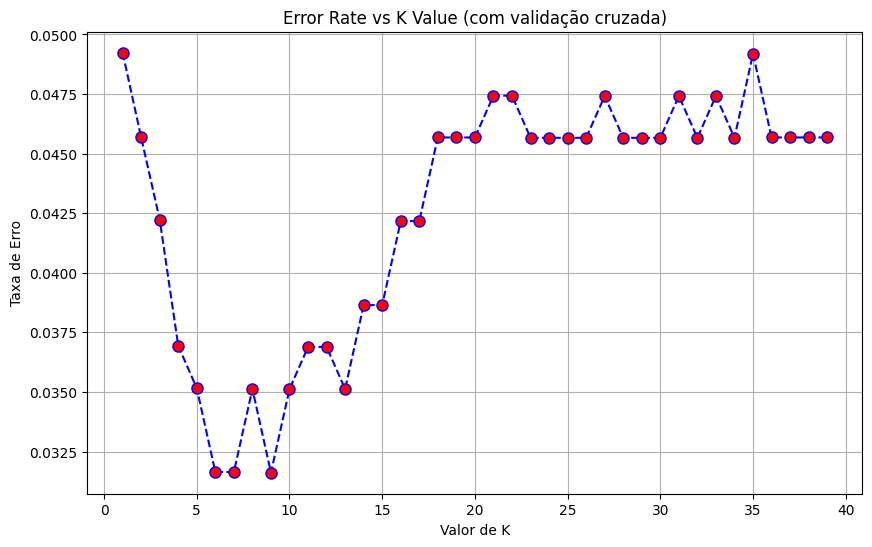

In [ ]:
error_rate = []

for k in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, X, y, cv=5)

    error = 1 - scores.mean()
    error_rate.append(error)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs K Value (com validação cruzada)')
plt.xlabel('Valor de K')
plt.ylabel('Taxa de Erro')
plt.grid(True)
plt.show()



A partir dos gráficos é possível perceber que o modelo que obteve melhor capacidade preditiva tinha o parâmetro **K=6**, **K=7** ou **K=8**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)

y_pred = cross_val_predict(knn, X, y, cv=cv)

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X, y, cv=5)
print(f"Acurácia em cada fold: {scores}")
print(f"Acurácia média: {np.mean(scores):.2f}")

[[354   3]
 [ 17 195]]
              precision    recall  f1-score   support

           B       0.95      0.99      0.97       357
           M       0.98      0.92      0.95       212

    accuracy                           0.96       569
   macro avg       0.97      0.96      0.96       569
weighted avg       0.97      0.96      0.96       569

Acurácia em cada fold: [0.97368421 0.95614035 0.98245614 0.96491228 0.96460177]
Acurácia média: 0.97
